### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp

### Load Datasets

#### Description of features
- **WDIR**: Wind direction
- **WSPD**: Wind speed
- **rWSPD**: Lagged wind speed
- **rWSPD_T**: Transformed lagged wind speed (for sikorsky)
- **Fetch**: Fetch distance

#### Description of target
- **SWHft**: Significant wave height (in feet)

In [2]:
df_buoy_04_13 = pd.read_csv('Data_Buoy_2004_2013.csv')
df_stn_04_13 = pd.read_csv('Data_Sikorsky_2004_2013.csv')
df_stn_73_04 = pd.read_csv('Data_Sikorsky_1973_2004.csv')

df_stn_04_13['WSPD_T'] = df_stn_04_13['rWSPD_T'].shift(-1).ffill()
df_stn_73_04['WSPD_T'] = df_stn_73_04['rWSPD_T'].shift(-1).ffill()

df1 = pd.concat([df_buoy_04_13[['TimeStamp_1','SWHft']], df_stn_04_13[['WSPD','WSPD_T','Fetch']]], axis=1)
df2 = df_stn_73_04[['TimeStamp_1', 'WSPD', 'WSPD_T', 'Fetch']].copy()

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

df1.head()

,SWHft,WSPD,WSPD_T,Fetch
TimeStamp_1,,,,
2004-11-01 00:00:00,3.249133,3.6,4.38474,16093.4
2004-11-01 01:00:00,3.249133,5.1,6.87748,16093.4
2004-11-01 02:00:00,1.960359,4.6,6.56483,16093.4
2004-11-01 03:00:00,2.001249,2.6,5.31423,16093.4
2004-11-01 04:00:00,3.254957,3.6,5.93953,16093.4


### Distribution of Features & Target

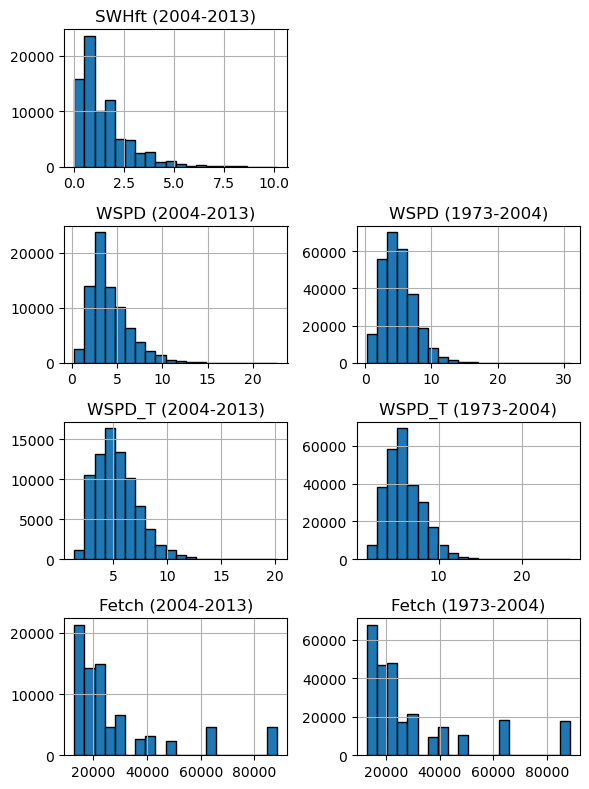

In [3]:
plt.figure(figsize=(6, 8))

# Numerical columns
num_cols = df1.columns

for i, col in enumerate(num_cols, start=1):
    # Left column: Histograms of df1 (2004-2013)
    plt.subplot(len(num_cols), 2, 2*i-1)
    df1[col].hist(bins=20, edgecolor='black')
    plt.title(f"{col} (2004-2013)")
    
    # Right column: Histograms of df2 (1973-2004)
    if i > 1:
        plt.subplot(len(num_cols), 2, 2*i)
        df2[col].hist(bins=20, edgecolor='black')
        plt.title(f"{col} (1973-2004)")

plt.tight_layout()
plt.show()

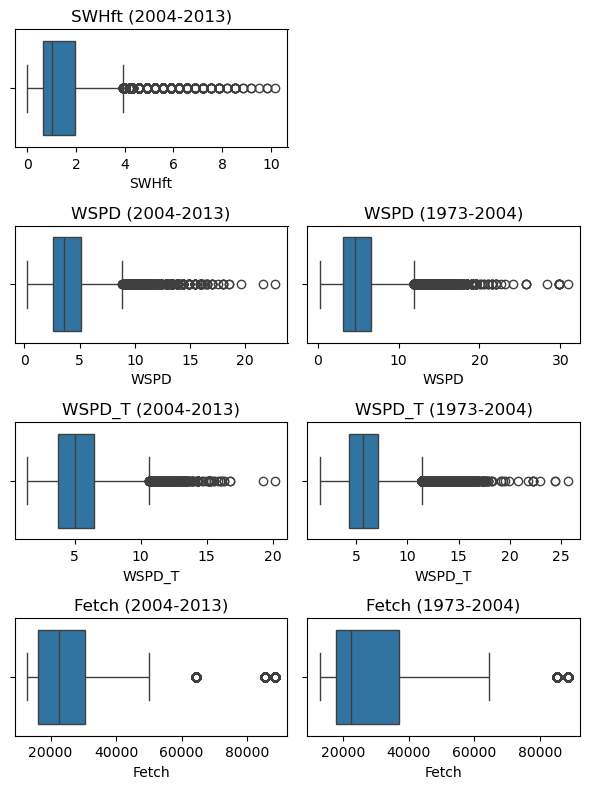

In [4]:
plt.figure(figsize=(6, 8))

# Numerical columns
num_cols = df1.columns

for i, col in enumerate(num_cols, start=1):
    # Left column: Box plots of df1 (2004-2013)
    plt.subplot(len(num_cols), 2, 2*i-1)
    sns.boxplot(data=df1, x=col)
    plt.title(f"{col} (2004-2013)")
    
    # Right column: Box plots of df2 (1973-2004)
    if i > 1:
        plt.subplot(len(num_cols), 2, 2*i)
        sns.boxplot(data=df2, x=col)
        plt.title(f"{col} (1973-2004)")

plt.tight_layout()
plt.show()

### Correlation Analysis

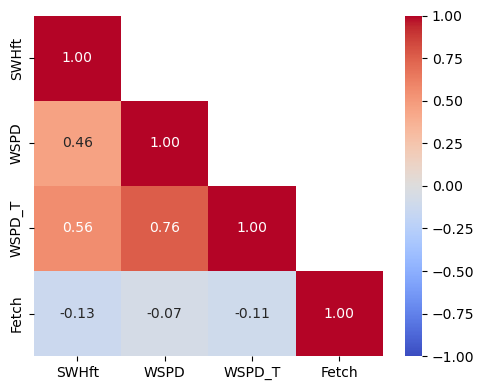

In [5]:
df_corr = df1.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, fmt='.2f', annot=True, 
            cmap='coolwarm', mask=np.triu(np.ones_like(df_corr), 1))

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov (KS) Test

- **Two-sample KS test**: To compare the distributions of a feature between the training set and the test set
- **Null hypothesis**: There is no significant difference between the distributions of two datasets.

#### Comparison of feature distributions between the training and test sets

In [6]:
# Train-Test split
seperate_date = pd.to_datetime('2005-10-31 23:59:00')
df_train = df1[df1.index > seperate_date]  # From 2005-11-01 00:00:00 to 2013-10-31 23:00:00
df_test = df1[df1.index < seperate_date]   # From 2004-11-01 00:00:00 to 2005-10-31 23:00:00

# Data normalization
scaler = MinMaxScaler()
df_train_T = scaler.fit_transform(df_train)
df_test_T = scaler.transform(df_test)
df_train_T = pd.DataFrame(df_train_T, columns = df1.columns)
df_test_T = pd.DataFrame(df_test_T, columns = df1.columns)

# KS test
results = []
for col in df1.columns:
    statistic, p_value = ks_2samp(df_train_T[col], df_test_T[col])
    results.append((col, statistic, p_value))

ks_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-Value'])
ks_df

,Feature,KS Statistic,P-Value
0,SWHft,0.148649,1.160664e-150
1,WSPD,0.031729,3.028056e-07
2,WSPD_T,0.023682,3.165492e-04
3,Fetch,0.037544,5.670412e-10


#### Comparison of feature distributions between the 2004-2013 and 1973-2004 datasets

In [7]:
# Drop columns
df1 = df1.drop(['SWHft'], axis=1)

# Data normalization
scaler = MinMaxScaler()
df1_T = scaler.fit_transform(df1)
df2_T = scaler.transform(df2)
df1_T = pd.DataFrame(df1_T, columns = df1.columns)
df2_T = pd.DataFrame(df2_T, columns = df2.columns)

# KS test
results = []
for col in df1.columns:
    statistic, p_value = ks_2samp(df1_T[col], df2_T[col])
    results.append((col, statistic, p_value))

ks_df = pd.DataFrame(results, columns=['Feature', 'KS Statistic', 'P-Value'])
ks_df

,Feature,KS Statistic,P-Value
0,WSPD,0.210112,0.000000e+00
1,WSPD_T,0.122588,0.000000e+00
2,Fetch,0.042513,1.860662e-96
